In [17]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

## Dataset
Time series deals with 2 columns, one is temporal ie: month in this case & another is the value to be forecasted ie: airplane passengers. To make plotting graphs easier, we set the index of pandas dataframe to the Month. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis.

In [19]:
dataset = pd.read_csv('AirPassengers.csv')
# Parse strings to datetime type and convert from string to datetime
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


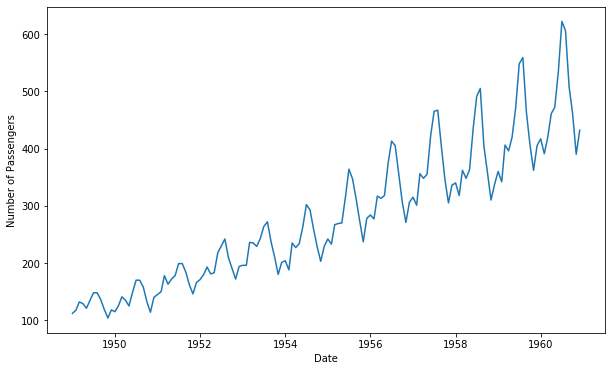

In [21]:
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.plot(indexedDataset)

From the plot, we can see that there is a Trend compoenent in the series. Hence, we now check for stationarity of the data.

In [22]:
# Determine rolling statistics.
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


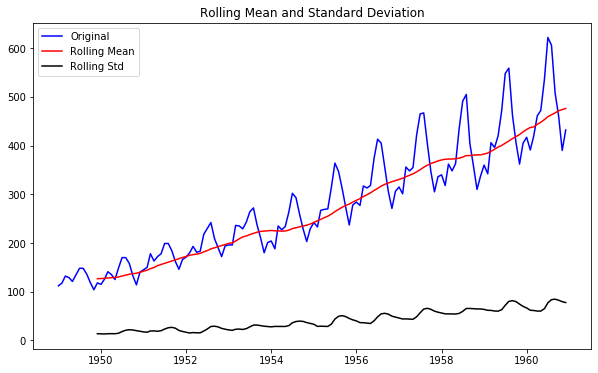

In [23]:
# Plot rolling statistics.
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which is not in our case.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

## Augmented Dickey–Fuller test

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

p value(0<=p<=1) should be as low as possible. Critical values at different confidence intervals should be close to the Test statistics value.

In [28]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

if dftest[1]<=0.05:
        print('strong evidence against the null hypothesis')
        print('reject the null hypothesis')
        print('data has no unit roots and is stationary')

else:
        print('weak evidence against the null hypothesis')
        print('fail to reject the null hypothesis')
        print('data has a unit root and is non-stationary')

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
weak evidence against the null hypothesis
fail to reject the null hypothesis
data has a unit root and is non-stationary


For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary.

## Data Transformation to achieve Stationarity 
There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on.

Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

## Log Scale Transformation

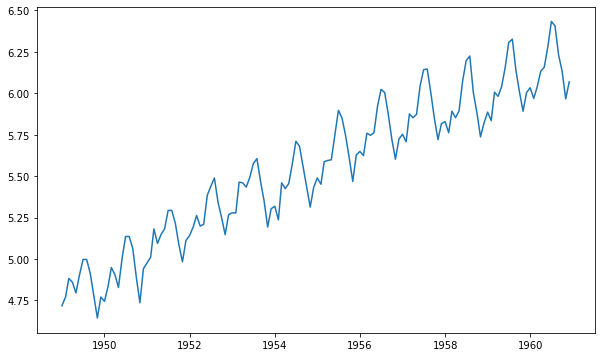

In [29]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

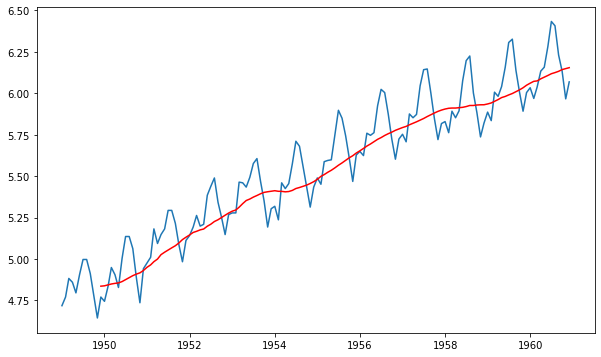

In [31]:
#The transformation makes series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()

plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

log_scale(L)=stationarypart(L1)+trend(LT) 
moving_avg_of_log_scale(A)=stationarypart(A1)+trend(AT) 

result_series(R)=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT) 

Since, L & A are series & it moving avg, their trend will be more or less same, Hence LT-AT nearly equals to 0.

Thus trend component will be almost removed. 
And we have, R=L1−A1 , our final non-trend curve.

In [32]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [34]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dftest[1]<=0.05:
        print('strong evidence against the null hypothesis')
        print('reject the null hypothesis')
        print('data has no unit roots and is stationary')

    else:
        print('weak evidence against the null hypothesis')
        print('fail to reject the null hypothesis')
        print('data has a unit root and is non-stationary')

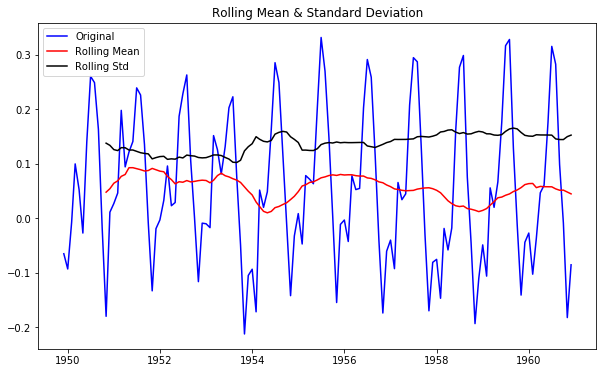

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
strong evidence against the null hypothesis
reject the null hypothesis
data has no unit roots and is stationary


In [35]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that "subtracting two related series having similar trend components will make the result stationary" is true. We find that:

1. p-value has reduced from 0.99 to 0.022(p<=0.05).
2. The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. 

Thus, from above 2 points, we can say that our given series is stationary.

But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.

## Exponential Decay Transformation

A quantity is subject to exponential decay if it decreases at a rate proportional to its current value. Symbolically, this process can be expressed by the following differential equation, where N is the quantity and λ (lambda) is a positive rate called the exponential decay constant:

dN/dt=−λN 
The solution to this equation (see derivation below) is:
N(t)=N0∗e−λt 
where N(t) is the quantity at time t, and N0 = N(0) is the initial quantity, i.e. the quantity at time t = 0.

Half Life is the time required for the decaying quantity to fall to one half of its initial value. It is denoted by  t1/2 . The half-life can be written in terms of the decay constant as:

t1/2=ln(2)/λ

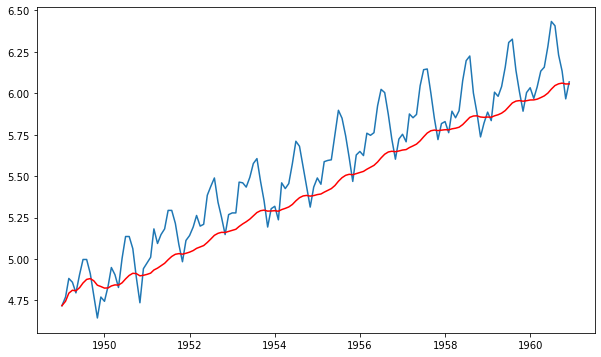

In [36]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')


From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.

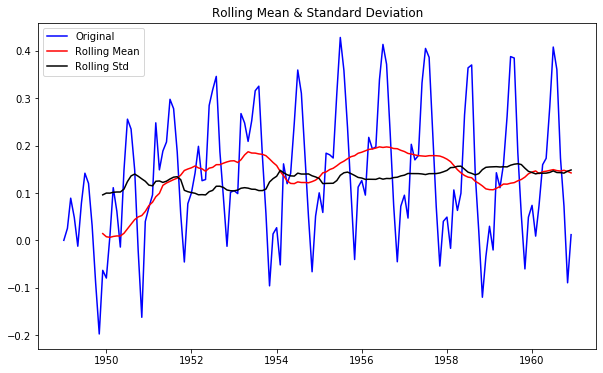

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
strong evidence against the null hypothesis
reject the null hypothesis
data has no unit roots and is stationary


In [37]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

1. p-value has decreased from 0.022 to 0.005.
2. Test Statistic value is very much closer to the Critical values.

Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.

But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:
x0,x1,x2,x3,....xn 
The shifted values will be:
null,x0,x1,x2,....xn  <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:
null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1)

## Time Shift Transformation

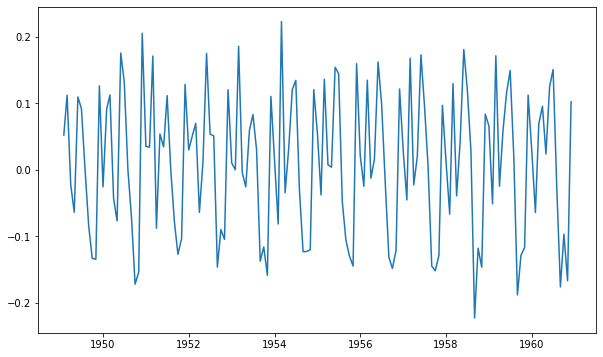

In [39]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

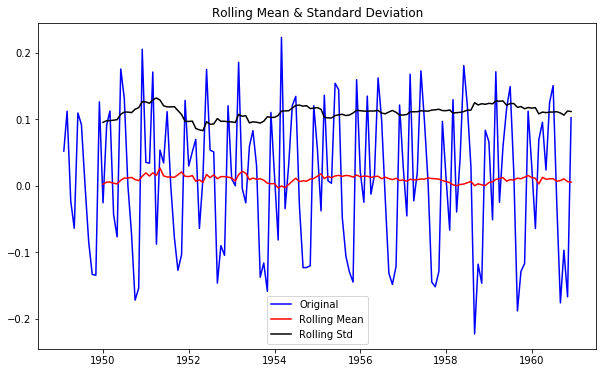

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
weak evidence against the null hypothesis
fail to reject the null hypothesis
data has a unit root and is non-stationary


In [40]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. 
But, the ADCF test shows us that:

1. p-value of 0.07 is not as good as 0.005 of exponential decay.
2. Test Statistic value not as close to the critical values as that for exponential decay.

We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

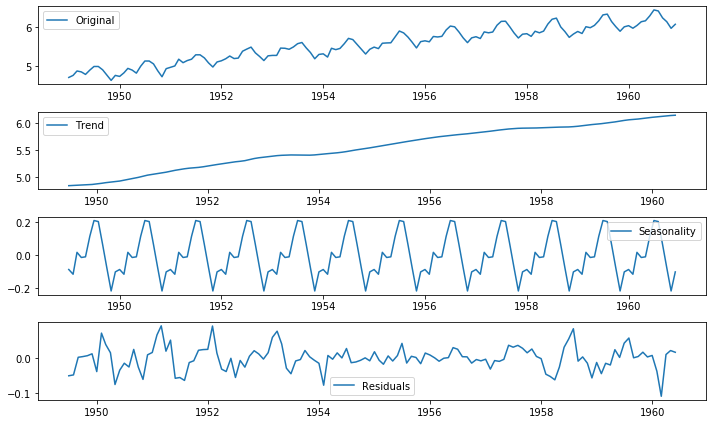

In [43]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

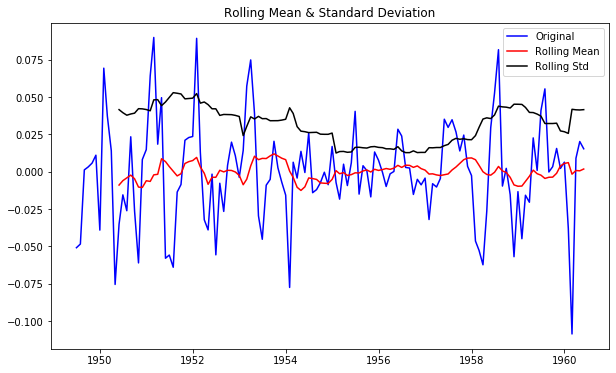

Results of Dickey Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64
strong evidence against the null hypothesis
reject the null hypothesis
data has no unit roots and is stationary


In [44]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

## Plotting ACF & PACF

We need to take help of ACF(Auto Correlation Function) & PACF(Partial Auto Correlation Function) plots. ACF & PACF graphs are used to find value of P & Q for ARIMA. We need to check, for which value in x-axis, graph line drops to 0 in y-axis for 1st time.
From PACF(at y=0), get P
From ACF(at y=0), get Q

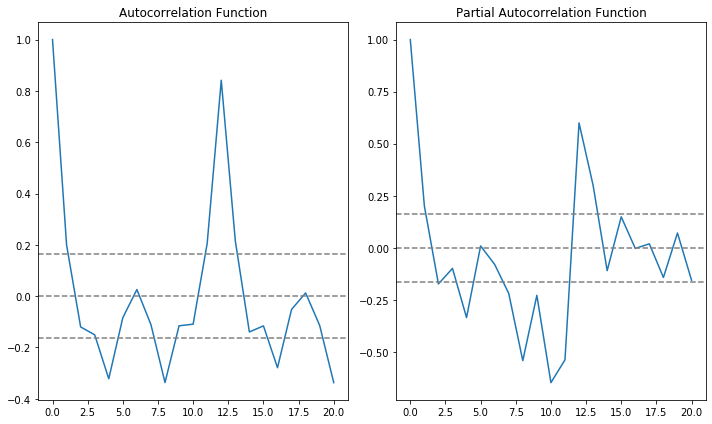

In [46]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2.
From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS(Residual Square Sum). Lower RSS values indicate a better model.

/Users/subhamsaha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/subhamsaha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


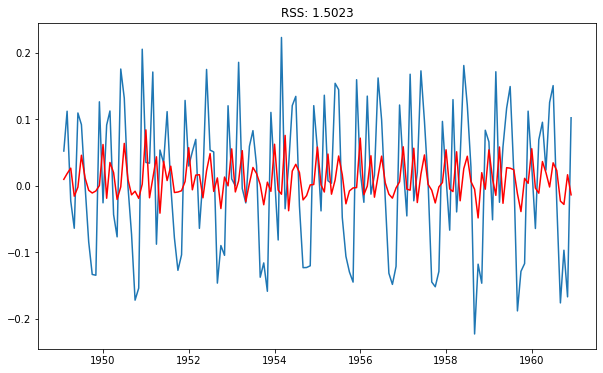

In [49]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

/Users/subhamsaha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/subhamsaha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting MA model


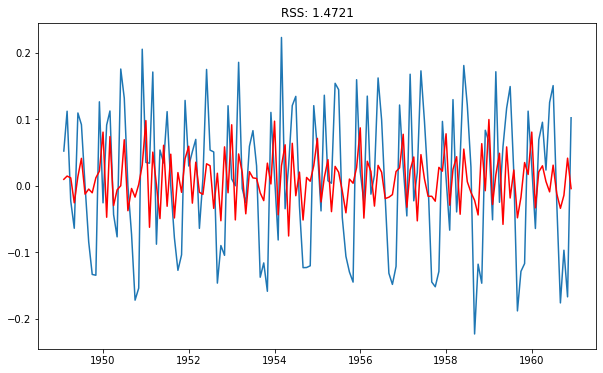

In [50]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

## ARIMA

ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

/Users/subhamsaha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/subhamsaha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


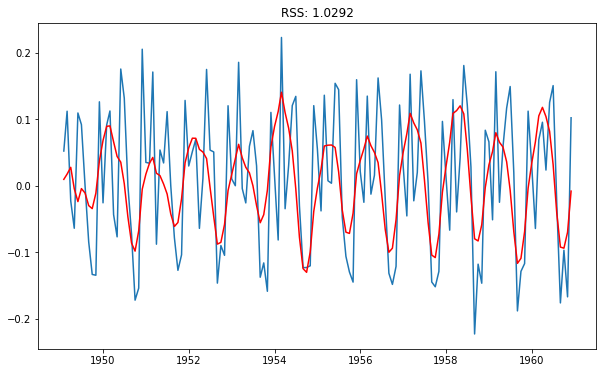

In [51]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

## Prediction & Reverse transformations

In [52]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [53]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372553
1960-09-01    1.280203
1960-10-01    1.186190
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64


In [54]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

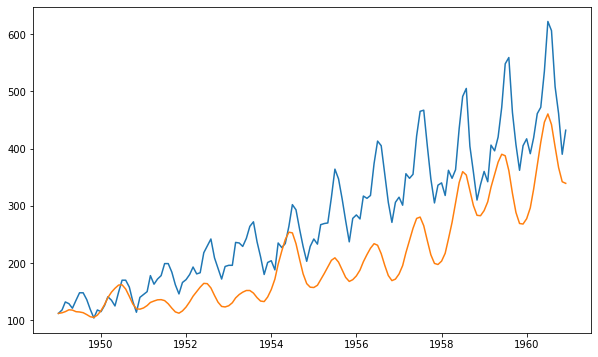

In [55]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [56]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


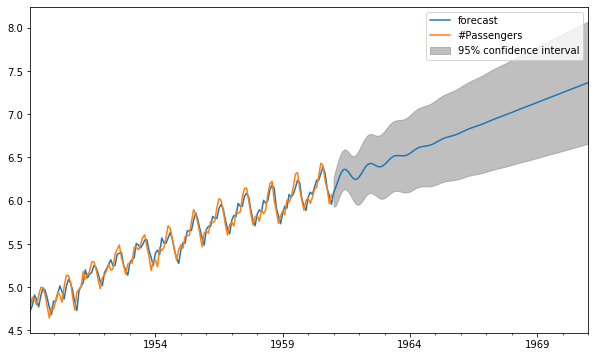

In [60]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) 
x=results_ARIMA.forecast(steps=120)

In [64]:
print(x[1])
print(len(x[1]))
print(np.exp(x[1]))

[0.08384711 0.10749462 0.11568695 0.11702775 0.11703497 0.11744018
 0.1176225  0.11778714 0.12024163 0.12736043 0.1387096  0.15118793
 0.16157814 0.16834395 0.17177329 0.17311982 0.17358732 0.17385459
 0.17430217 0.17543331 0.17788146 0.18195721 0.18726217 0.19283393
 0.19769245 0.20130639 0.20369055 0.20519832 0.20625268 0.20720998
 0.2083697  0.21000325 0.21229743 0.21524478 0.21860179 0.22198256
 0.22503064 0.22755294 0.22954806 0.23114797 0.23253824 0.23390533
 0.23541309 0.2371831  0.23926536 0.24161536 0.2441037  0.24656356
 0.24885255 0.25089628 0.25269732 0.25431626 0.2558431  0.25737226
 0.25898388 0.26072848 0.26261546 0.26461087 0.26664896 0.26865479
 0.27056846 0.27236094 0.27403699 0.27562771 0.27717827 0.27873524
 0.28033588 0.28200015 0.28372679 0.28549507 0.28727207 0.28902342
 0.29072334 0.2923608  0.29394038 0.29547873 0.29699865 0.29852273
 0.30006777 0.30164124 0.3032401  0.30485264 0.30646252 0.3080538
 0.30961537 0.31114334 0.3126412  0.31411792 0.315585   0.31705